In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow import random

## Setup Environment

In [18]:
# Load the data
sunspots = pd.read_csv('monthly-sunspots.csv', usecols=[1], engine='python')

In [19]:
# Review loaded data
print(sunspots.dtypes)
sunspots.head()

Sunspots    float64
dtype: object


,Sunspots
0,58.0
1,62.6
2,70.0
3,55.7
4,85.0


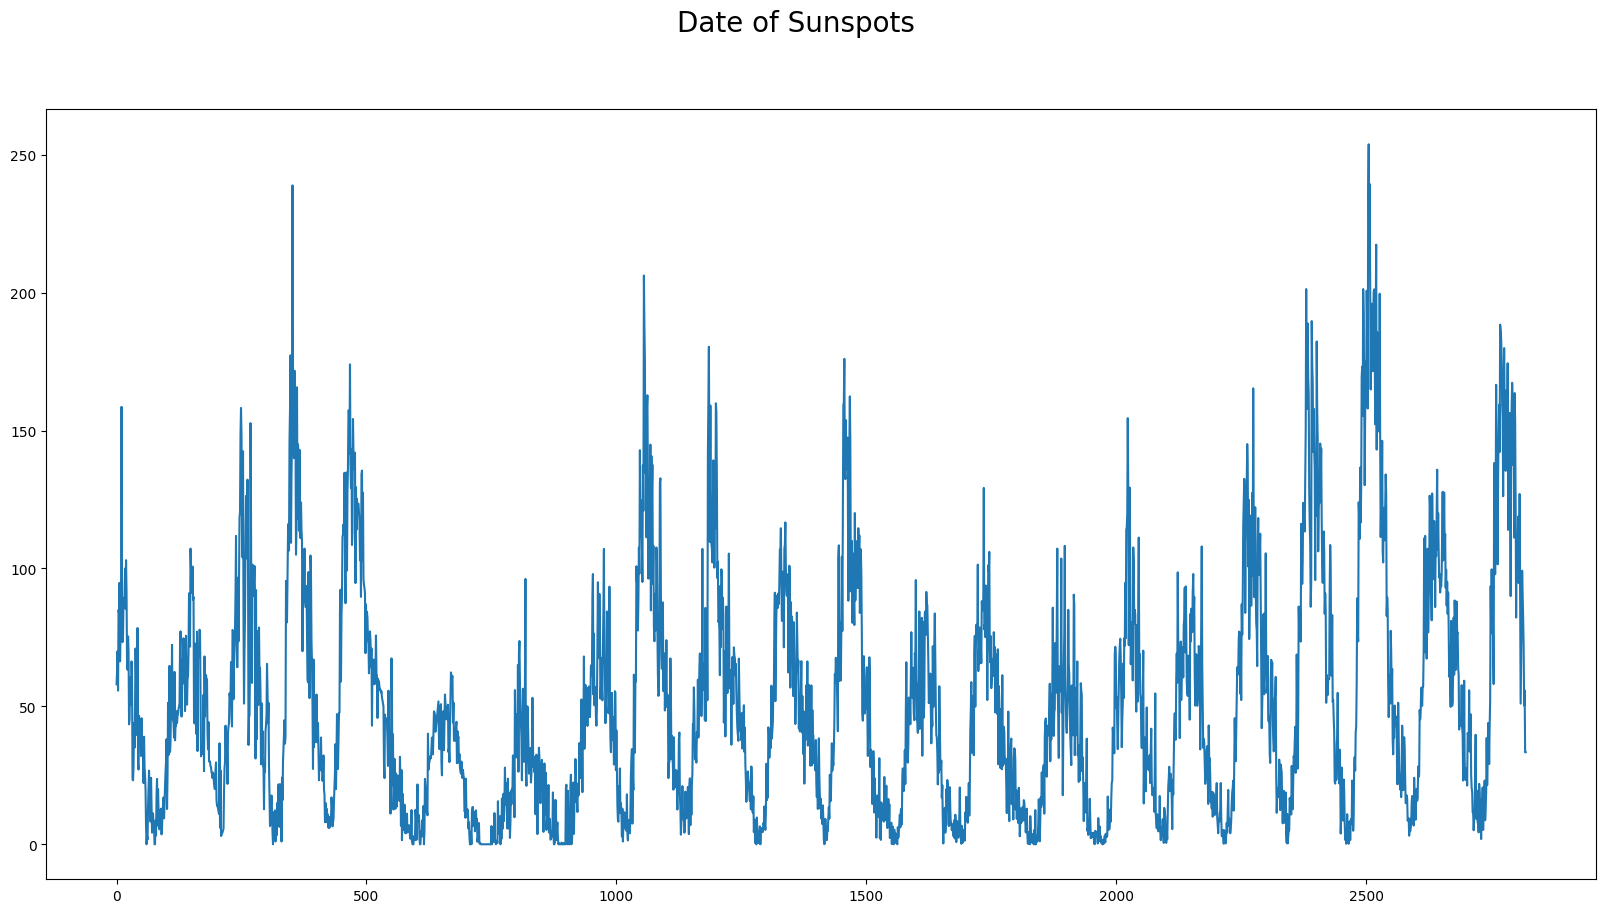

In [20]:
# Plot the data to visualize the stock price
plt.figure(figsize=(20,10)).suptitle("Date of Sunspots", fontsize=20)
plt.plot(sunspots["Sunspots"])
plt.show()

In [21]:
# Scale the Data
# Use MinMaxScaler instead of StandardScaler with feature_range = (0,1)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_sunspots = scaler.fit_transform(sunspots[["Sunspots"]].values)

In [22]:
# Get the total size of the sequence
total_size = len(scaled_sunspots)

# Test dataset size (20 percent of data)
test_size = int(total_size * 0.2)

# Training dataset size
train_size = total_size - test_size

# Print the train size and test size
print(train_size, test_size)

2256 564


In [23]:
# Split data into Training and Test sets
training_sunspots = scaled_sunspots[0:train_size,:]
test_sunspots = scaled_sunspots[train_size:,:]

# Print shape of training_sunspots and test_sunspots
print(training_sunspots.shape, test_sunspots.shape)

(2256, 1) (564, 1)


# Create Dataset for RNN

In [24]:
# Prepare RNN Dataset. 
# Each data point (X) is linked to the previous data points of size=lookback
# The predicted value (Y) is the next point

def create_rnn_dataset(data, lookback=1):
    
    data_x, data_y = [], []
    for i in range(len(data)- lookback -1):
        #All points from this point, looking backwards upto lookback
        a = data[i:(i+ lookback), 0]
        data_x.append(a)
        #The next point
        data_y.append(data[i + lookback, 0])
    return np.array(data_x), np.array(data_y)

In [25]:
# lookback for 12 previous days
lookback = 12

# Create X and Y for training
train_req_x, train_req_y = create_rnn_dataset(training_sunspots, lookback)

# Reshape for use with RNN
train_req_x = np.reshape(train_req_x,
                         (train_req_x.shape[0],1, train_req_x.shape[1]))

print("Shapes of X, Y: ",train_req_x.shape, train_req_y.shape)

Shapes of X, Y:  (2243, 1, 12) (2243,)


## Build the RNN Model

In [26]:
random.set_seed(3)

# Create a Keras Model
sunspots_model=Sequential()

# Add Simple RNN layer with 32 nodes with an input shape of (1,lookback)
sunspots_model.add(SimpleRNN(32, input_shape=(1,lookback)))

# Add a Dense layer at the end for output with 1 unit
sunspots_model.add(Dense(1))

In [27]:
# Compile the model using mean_squared_error for loss, adam as the optimizer, and mse for metrics
sunspots_model.compile(loss="mean_squared_error",
                    optimizer="adam",
                    metrics=["mse"])

In [28]:
# Print model summary
sunspots_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1440      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1473 (5.75 KB)
Trainable params: 1473 (5.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
# Train the model with 3 epochs, and 1 batch size
sunspots_model.fit(train_req_x, train_req_y,
                epochs=3, batch_size=1, verbose=1)

Epoch 1/3
2243/2243 [==============================] - 1s 338us/step - loss: 0.0056 - mse: 0.0056
Epoch 2/3
2243/2243 [==============================] - 1s 327us/step - loss: 0.0041 - mse: 0.0041
Epoch 3/3
2243/2243 [==============================] - 1s 325us/step - loss: 0.0041 - mse: 0.0041


## Test the Model

In [30]:
# Preprocess the test dataset, the same way training set is processed
test_req_x, test_req_y = create_rnn_dataset(test_sunspots, lookback)

# Print the shape of test_req_x and test_req_y
print(test_req_x.shape, test_req_y.shape)

(551, 12) (551,)


In [31]:
# Reshape the data
test_req_x = np.reshape(test_req_x,
                        (test_req_x.shape[0],1, test_req_x.shape[1]))

# Print the shape of test_req_x and test_req_y after reshaping
print(test_req_x.shape, test_req_y.shape)

(551, 1, 12) (551,)


In [32]:
# Evaluate the model
sunspots_model.evaluate(test_req_x, test_req_y, verbose=1)

18/18 [==============================] - 0s 370us/step - loss: 0.0064 - mse: 0.0064


[0.006401216145604849, 0.006401216145604849]

In [33]:
# Predict on the test dataset
predict_on_test = sunspots_model.predict(test_req_x)

# Inverse the scaling to view results
predict_on_test = scaler.inverse_transform(predict_on_test)

18/18 [==============================] - 0s 327us/step


## Visualize the Results

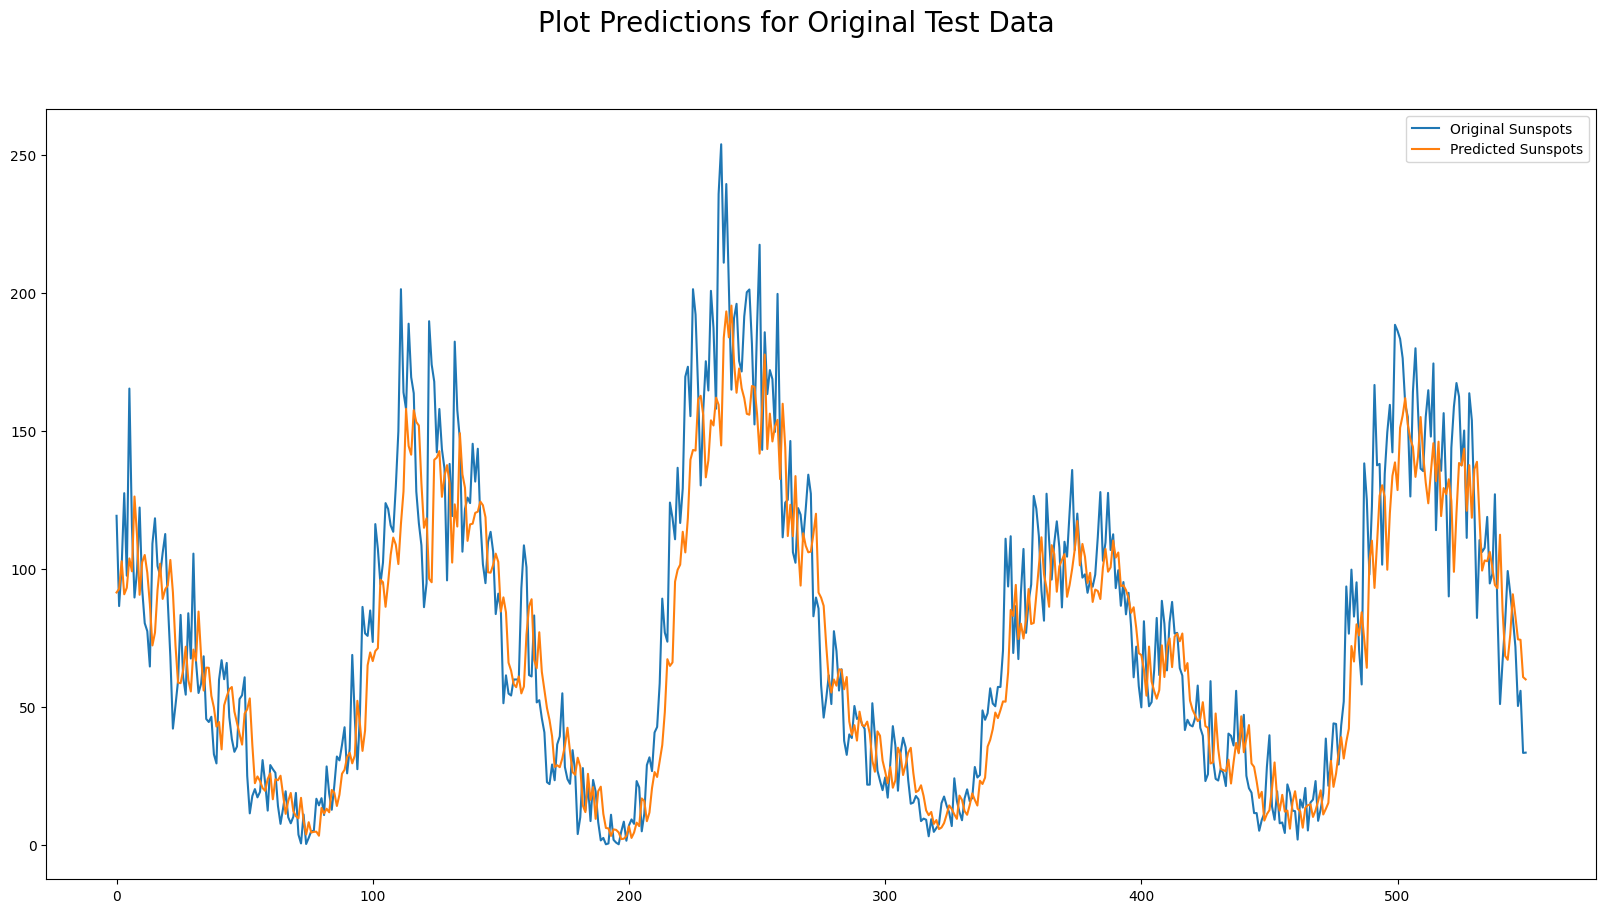

In [34]:
# Extract original new values that map to the same dates on the predicted new values
orig_test_values = sunspots[["Sunspots"]].loc[total_size-len(predict_on_test):]
orig_test_values.reset_index(drop=True, inplace=True)

plt.figure(figsize=(20,10)).suptitle("Plot Predictions for Original Test Data", fontsize=20)
plt.plot(orig_test_values, label="Original Sunspots")
plt.plot(predict_on_test, label="Predicted Sunspots")
plt.legend()
plt.show()

## Predictions

In [35]:
def create_synthetic_sunspots():
    temp = 0
    temp_sunspots = []
    for i in sunspots["Sunspots"].values:
        if temp < 12:
            e = i + np.random.rand()
            temp_sunspots.append(e)
        else:
            break
        temp = temp  +1
    return np.array(temp_sunspots)

In [36]:
# Get sample data
new_sunspots = create_synthetic_sunspots()

# Scale
scaled_sunspots = scaler.transform(new_sunspots.reshape(-1,1))

# Reshape scaled_sunspots
model_input_sunspots = np.reshape(scaled_sunspots,
                                  (scaled_sunspots.shape[1],1, scaled_sunspots.shape[0]))

In [38]:
# Predict on the test dataset
predict_on_new = sunspots_model.predict(model_input_sunspots)

# Scale the data back
norm_prediction = scaler.inverse_transform(predict_on_new)

# Print the prediction of the next sunspot
print("The next sunspot is predicted to be :", norm_prediction[0][0])

1/1 [==============================] - 0s 8ms/step
The next sunspot is predicted to be : 88.25057


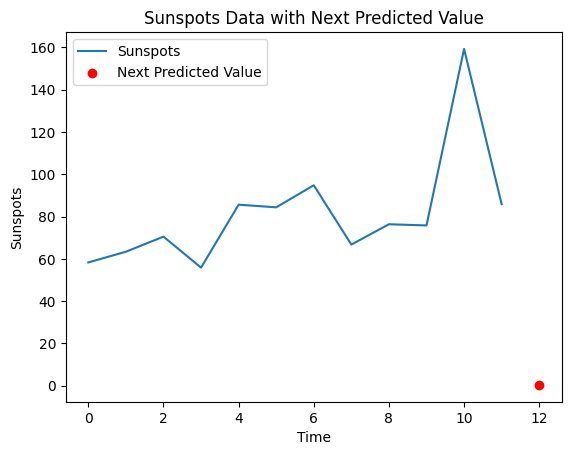

In [40]:
# Plot the new_sunspots as a line graph and add the next predicted value as a data point on the graph.
# You can use plt.scatter to plot the new predicted data point.
plt.plot(new_sunspots, label='Sunspots')
plt.scatter(len(new_sunspots), predict_on_new, color='red', label='Next Predicted Value')
plt.xlabel('Time')
plt.ylabel('Sunspots')
plt.title('Sunspots Data with Next Predicted Value')
plt.legend()
plt.show()